In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from utils import *

import xgboost as xgb

seed=42
PATH = Path('data')
list(PATH.iterdir())

[PosixPath('data/submission'),
 PosixPath('data/train_day8_3to16_FE.feather'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/train_day9_3to16_FE.feather'),
 PosixPath('data/xgb2.model'),
 PosixPath('data/train_sample.csv'),
 PosixPath('data/train_day7_3to16_FE.feather'),
 PosixPath('data/dtree.dot'),
 PosixPath('data/test_FE.feather'),
 PosixPath('data/xgb1.model'),
 PosixPath('data/val_idxs.p'),
 PosixPath('data/mean_enc_df'),
 PosixPath('data/xgb1_noratio.model'),
 PosixPath('data/validation')]

In [2]:
# def metric(rf,X_val,y_val):
#     y_val_pred = rf.predict_proba(X_val)[:,1]
#     return roc_auc_score(y_val,y_val_pred)

# def permutation_importances(rf,X_val,y_val,metric):
#     baseline = metric(rf,X_val,y_val)
#     imp=[]
#     for col in X_val.columns:
#         save = X_val[col].copy()
#         X_val[col] = np.random.permutation(X_val[col])
#         m = metric(rf,X_val,y_val)
#         print(f'Score after {col} perm: {m:.5f}')
#         X_val[col] = save
#         imp.append(baseline-m)
#     return np.array(imp)



# Sample run

In [2]:
cols_to_drop=['is_attributed','ip','day']

In [4]:
val_names = [str(i) for i in list((PATH/'validation').iterdir())]
val_names

['data/validation/val3.feather',
 'data/validation/val2.feather',
 'data/validation/val0.feather',
 'data/validation/val1.feather']

In [3]:
train_df,y_train = get_train(cols_to_drop,10000000)

In [6]:
# params = {'colsample_bytree': 0.7, 
#           'eval_metric': 'auc', 
#           'learning_rate': 0.1, 
#           'max_depth': 4, 
#           'min_child_weight': 100, 
#           'objective': 'binary:logistic', 
#           'seed': seed, 
#           'subsample': 0.9500000000000001,
#           'scale_pos_weight': 100,
#           'tree_method': 'gpu_hist'}
params = {'colsample_bytree': 0.7000000000000001, 
          'eval_metric': 'auc', 
          'gamma': 0.15000000000000002, 
          'learning_rate': 0.2,
          'max_leaf_nodes': 137, 
          'min_child_weight': 234, 
          'objective': 'binary:logistic', 
          'scale_pos_weight': 174, 
          'seed': 42, 
          'subsample': 0.65, 
          'tree_method': 'gpu_hist'}

dtrain = xgb.DMatrix(train_df,y_train)
del train_df,y_train
gc.collect()

val_names=['data/validation/val3.feather']
for i in val_names:           
    val_df,y_val = get_val_by_name(cols_to_drop,i)
    dval = xgb.DMatrix(val_df,y_val)
    
    del val_df,y_val
    gc.collect()

    watchlist = [(dtrain, 'train'), (dval, 'valid')]
    xgb_model = xgb.train(params, dtrain, 2000, watchlist,
                      verbose_eval=50, 
                      early_stopping_rounds=70)

    train_pred = xgb_model.predict(dtrain,ntree_limit=xgb_model.best_ntree_limit)
    val_pred = xgb_model.predict(dval,ntree_limit=xgb_model.best_ntree_limit)

    train_loss = roc_auc_score(dtrain.get_label(),train_pred)
    val_loss = roc_auc_score(dval.get_label(),val_pred)
    print(f'Train AUC: {train_loss}. Val AUC: {val_loss}. Best ite: {xgb_model.best_ntree_limit}')

    del dval
#     xgb_model.__del__()
    gc.collect()
    

0

0

[0]	train-auc:0.969104	valid-auc:0.957411
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 70 rounds.
[50]	train-auc:0.98662	valid-auc:0.969596
[100]	train-auc:0.991689	valid-auc:0.969271
Stopping. Best iteration:
[43]	train-auc:0.985276	valid-auc:0.970135

Train AUC: 0.9852763716784059. Val AUC: 0.9701347341334815. Best ite: 44


21

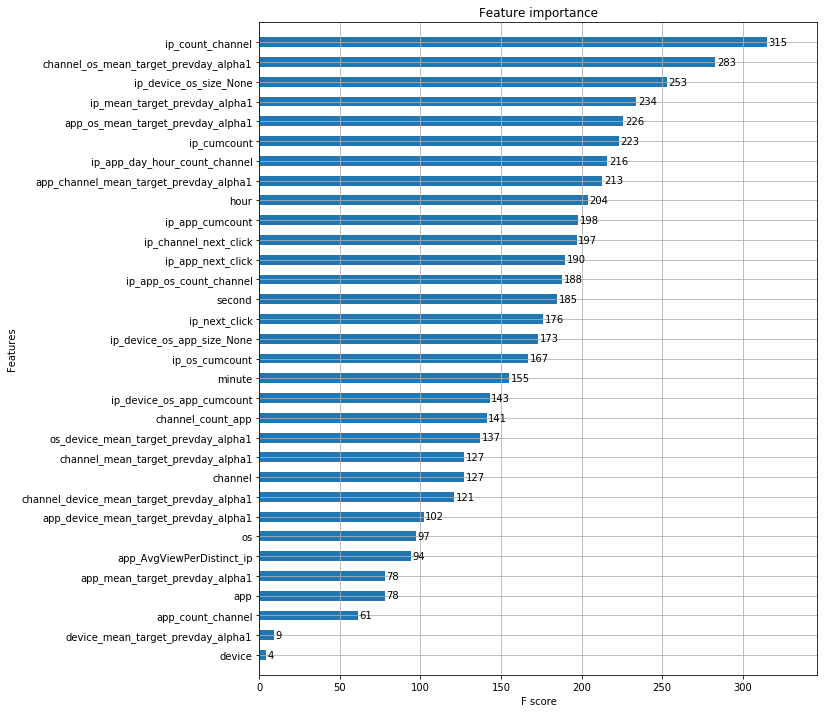

In [7]:
fig, ax = plt.subplots(figsize=(10,12))
xgb.plot_importance(xgb_model,ax=ax,height=.5)

# Hypertuning

In [3]:
cols_to_drop=['is_attributed','ip','day']
train_df,y_train = get_train(cols_to_drop,10000000)

In [5]:
train_df.shape
y_train.shape

(10000000, 32)

(10000000,)

In [4]:
val_name = 'data/validation/val3.feather'
val_df,y_val = get_val_by_name(cols_to_drop,val_name)

dtrain = xgb.DMatrix(train_df,y_train)
dval = xgb.DMatrix(val_df,y_val)

del train_df,y_train,val_df,y_val
gc.collect()

0

In [5]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

val_losses=[]
ites=[]



def score(params):
    print("Training with params: ")
    print(params)



    watchlist = [(dtrain, 'train'), (dval, 'valid')]
    xgb_model = xgb.train(params, dtrain, 2000, watchlist,
                      verbose_eval=False, 
                      early_stopping_rounds=100)

    train_pred = xgb_model.predict(dtrain,ntree_limit=xgb_model.best_ntree_limit)
    val_pred = xgb_model.predict(dval,ntree_limit=xgb_model.best_ntree_limit)

    train_loss = roc_auc_score(dtrain.get_label(),train_pred)
    val_loss = roc_auc_score(dval.get_label(),val_pred)
    val_losses.append(val_loss)
    ites.append(xgb_model.best_ntree_limit)
    print(f'Train AUC: {train_loss}. Val AUC: {val_loss}. Best ite: {xgb_model.best_ntree_limit}')

    xgb_model.__del__()

    gc.collect()
    
    
    return {'loss': val_loss, 'status': STATUS_OK}

def optimize(space,max_evals=5):
    
    best = fmin(score, space, algo=tpe.suggest, 
        # trials=trials, 
        max_evals=max_evals)
    return best

In [ ]:

space = {
    #'n_estimators': hp.quniform('n_estimators', 50, 500, 5),
#     'max_depth': hp.choice('max_depth', np.arange(5, 10, dtype=int)),
    'subsample': hp.quniform('subsample', 0.5, .95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, .95, 0.05),
    'gamma': hp.quniform('gamma', 0, 1, 0.05),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', np.arange(100,200, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(100,300, dtype=int)),
    'scale_pos_weight': hp.choice('scale_pos_weight', np.arange(100,200, dtype=int)),
    'learning_rate': 0.2,
    'eval_metric': 'auc', 
    'objective': 'binary:logistic', 
    'seed': seed,'tree_method':'gpu_hist'
}
best_hyperparams = optimize(space,max_evals=400)
print("The best hyperparameters are: ")
print(best_hyperparams)

Training with params: 
{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'auc', 'gamma': 0.4, 'learning_rate': 0.2, 'max_leaf_nodes': 169, 'min_child_weight': 258, 'objective': 'binary:logistic', 'scale_pos_weight': 142, 'seed': 42, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
Train AUC: 0.9893705106663817. Val AUC: 0.9702714770404105. Best ite: 72
Training with params: 
{'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.5, 'learning_rate': 0.2, 'max_leaf_nodes': 169, 'min_child_weight': 270, 'objective': 'binary:logistic', 'scale_pos_weight': 141, 'seed': 42, 'subsample': 0.6000000000000001, 'tree_method': 'gpu_hist'}
Train AUC: 0.9879651540210793. Val AUC: 0.9705380508058978. Best ite: 64
Training with params: 
{'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.55, 'learning_rate': 0.2, 'max_leaf_nodes': 183, 'min_child_weight': 117, 'objective': 'binary:logistic', 'scale_pos_weight': 137, 'seed': 42, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
Train AUC: 0

Train AUC: 0.9850566859320673. Val AUC: 0.9693352441381687. Best ite: 43
Training with params: 
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'auc', 'gamma': 0.30000000000000004, 'learning_rate': 0.2, 'max_leaf_nodes': 185, 'min_child_weight': 245, 'objective': 'binary:logistic', 'scale_pos_weight': 184, 'seed': 42, 'subsample': 0.5, 'tree_method': 'gpu_hist'}
Train AUC: 0.9871681877289686. Val AUC: 0.9694216440140913. Best ite: 53
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.30000000000000004, 'learning_rate': 0.2, 'max_leaf_nodes': 141, 'min_child_weight': 171, 'objective': 'binary:logistic', 'scale_pos_weight': 109, 'seed': 42, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
Train AUC: 0.9882772147255582. Val AUC: 0.9698041951822602. Best ite: 68
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.30000000000000004, 'learning_rate': 0.2, 'max_leaf_nodes': 112, 'min_child_weight': 171, 'objective': 'binary:log

Train AUC: 0.9874957265264901. Val AUC: 0.9699226781846803. Best ite: 54
Training with params: 
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'auc', 'gamma': 0.6000000000000001, 'learning_rate': 0.2, 'max_leaf_nodes': 181, 'min_child_weight': 141, 'objective': 'binary:logistic', 'scale_pos_weight': 138, 'seed': 42, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
Train AUC: 0.9857634498051464. Val AUC: 0.9691097296084852. Best ite: 45
Training with params: 
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'auc', 'gamma': 0.6000000000000001, 'learning_rate': 0.2, 'max_leaf_nodes': 124, 'min_child_weight': 244, 'objective': 'binary:logistic', 'scale_pos_weight': 138, 'seed': 42, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
Train AUC: 0.9846998863466102. Val AUC: 0.9699073492469809. Best ite: 41
Training with params: 
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'auc', 'gamma': 0.75, 'learning_rate': 0.2, 'max_leaf_nodes': 181, 'min_child_weight': 136, 'objective

Train AUC: 0.9866883037700453. Val AUC: 0.9694889056570044. Best ite: 53
Training with params: 
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'auc', 'gamma': 0.15000000000000002, 'learning_rate': 0.2, 'max_leaf_nodes': 151, 'min_child_weight': 172, 'objective': 'binary:logistic', 'scale_pos_weight': 186, 'seed': 42, 'subsample': 0.5, 'tree_method': 'gpu_hist'}
Train AUC: 0.9871351402991793. Val AUC: 0.9693193388287054. Best ite: 52
Training with params: 
{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.4, 'learning_rate': 0.2, 'max_leaf_nodes': 173, 'min_child_weight': 165, 'objective': 'binary:logistic', 'scale_pos_weight': 193, 'seed': 42, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
Train AUC: 0.9860562880242311. Val AUC: 0.9698964314611446. Best ite: 42
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.30000000000000004, 'learning_rate': 0.2, 'max_leaf_nodes': 122, 'min_child_weight': 107, 'objective': 'binary:logistic', 'scale_p

Train AUC: 0.9847491273521756. Val AUC: 0.970066619672336. Best ite: 40
Training with params: 
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'auc', 'gamma': 0.8, 'learning_rate': 0.2, 'max_leaf_nodes': 101, 'min_child_weight': 107, 'objective': 'binary:logistic', 'scale_pos_weight': 194, 'seed': 42, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
Train AUC: 0.987970805408512. Val AUC: 0.9695520696293387. Best ite: 52
Training with params: 
{'colsample_bytree': 0.9500000000000001, 'eval_metric': 'auc', 'gamma': 0.35000000000000003, 'learning_rate': 0.2, 'max_leaf_nodes': 113, 'min_child_weight': 214, 'objective': 'binary:logistic', 'scale_pos_weight': 155, 'seed': 42, 'subsample': 0.6000000000000001, 'tree_method': 'gpu_hist'}
Train AUC: 0.9860992467317702. Val AUC: 0.9698290429411993. Best ite: 44
Training with params: 
{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.5, 'learning_rate': 0.2, 'max_leaf_nodes': 170, 'min_child_weight': 205, 'objective': 'binary:logisti

Train AUC: 0.9868405302501027. Val AUC: 0.9701818117666842. Best ite: 46
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.2, 'learning_rate': 0.2, 'max_leaf_nodes': 144, 'min_child_weight': 113, 'objective': 'binary:logistic', 'scale_pos_weight': 102, 'seed': 42, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
Train AUC: 0.9870196884403905. Val AUC: 0.9692667181326211. Best ite: 53
Training with params: 
{'colsample_bytree': 0.75, 'eval_metric': 'auc', 'gamma': 0.25, 'learning_rate': 0.2, 'max_leaf_nodes': 167, 'min_child_weight': 150, 'objective': 'binary:logistic', 'scale_pos_weight': 133, 'seed': 42, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
Train AUC: 0.9906220417193558. Val AUC: 0.9705649106438685. Best ite: 76
Training with params: 
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.2, 'max_leaf_nodes': 136, 'min_child_weight': 131, 'objective': 'binary:logistic', 'scale_pos_weight': 187, 'seed': 42, '

Train AUC: 0.9867235979685129. Val AUC: 0.969936709838776. Best ite: 47
Training with params: 
{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.6000000000000001, 'learning_rate': 0.2, 'max_leaf_nodes': 197, 'min_child_weight': 223, 'objective': 'binary:logistic', 'scale_pos_weight': 156, 'seed': 42, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
Train AUC: 0.9881613017505381. Val AUC: 0.970693145086745. Best ite: 58
Training with params: 
{'colsample_bytree': 0.75, 'eval_metric': 'auc', 'gamma': 0.2, 'learning_rate': 0.2, 'max_leaf_nodes': 130, 'min_child_weight': 190, 'objective': 'binary:logistic', 'scale_pos_weight': 195, 'seed': 42, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
Train AUC: 0.9857676675861354. Val AUC: 0.9697318720191221. Best ite: 45
Training with params: 
{'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.75, 'learning_rate': 0.2, 'max_leaf_nodes': 194, 'min_child_weight': 139, 'objective': 'binary:logistic', 'scale_pos_weight': 106,

Train AUC: 0.9843433159551037. Val AUC: 0.9694199168130493. Best ite: 38
Training with params: 
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'auc', 'gamma': 0.45, 'learning_rate': 0.2, 'max_leaf_nodes': 159, 'min_child_weight': 126, 'objective': 'binary:logistic', 'scale_pos_weight': 108, 'seed': 42, 'subsample': 0.6000000000000001, 'tree_method': 'gpu_hist'}
Train AUC: 0.988294462361102. Val AUC: 0.9700753724551019. Best ite: 61
Training with params: 
{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'auc', 'gamma': 0.6000000000000001, 'learning_rate': 0.2, 'max_leaf_nodes': 172, 'min_child_weight': 292, 'objective': 'binary:logistic', 'scale_pos_weight': 175, 'seed': 42, 'subsample': 0.5, 'tree_method': 'gpu_hist'}
Train AUC: 0.9879001057290252. Val AUC: 0.9701473897854493. Best ite: 63
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.65, 'learning_rate': 0.2, 'max_leaf_nodes': 188, 'min_child_weight': 153, 'objective': 'binary:logist

Train AUC: 0.9909448223132163. Val AUC: 0.9701784855104377. Best ite: 85
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.30000000000000004, 'learning_rate': 0.2, 'max_leaf_nodes': 142, 'min_child_weight': 272, 'objective': 'binary:logistic', 'scale_pos_weight': 149, 'seed': 42, 'subsample': 0.6000000000000001, 'tree_method': 'gpu_hist'}
Train AUC: 0.9864776261387564. Val AUC: 0.9696937445874992. Best ite: 49
Training with params: 
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'auc', 'gamma': 0.55, 'learning_rate': 0.2, 'max_leaf_nodes': 133, 'min_child_weight': 132, 'objective': 'binary:logistic', 'scale_pos_weight': 191, 'seed': 42, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
Train AUC: 0.9910818686001559. Val AUC: 0.9704045688585062. Best ite: 81
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.2, 'learning_rate': 0.2, 'max_leaf_nodes': 186, 'min_child_weight': 218, 'objective': 'binary:logistic', 'scale_p

Train AUC: 0.9904054905276143. Val AUC: 0.9700406817285478. Best ite: 80
Training with params: 
{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.30000000000000004, 'learning_rate': 0.2, 'max_leaf_nodes': 170, 'min_child_weight': 191, 'objective': 'binary:logistic', 'scale_pos_weight': 155, 'seed': 42, 'subsample': 0.6000000000000001, 'tree_method': 'gpu_hist'}
Train AUC: 0.9885589302029987. Val AUC: 0.9703230611335726. Best ite: 65
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.15000000000000002, 'learning_rate': 0.2, 'max_leaf_nodes': 117, 'min_child_weight': 293, 'objective': 'binary:logistic', 'scale_pos_weight': 144, 'seed': 42, 'subsample': 0.5, 'tree_method': 'gpu_hist'}
Train AUC: 0.9866467077770613. Val AUC: 0.9699976852324002. Best ite: 56
Training with params: 
{'colsample_bytree': 0.75, 'eval_metric': 'auc', 'gamma': 0.55, 'learning_rate': 0.2, 'max_leaf_nodes': 187, 'min_child_weight': 166, 'objective': 'binary:logistic', 'scale_

Train AUC: 0.9885050723631208. Val AUC: 0.970150942447679. Best ite: 63
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.0, 'learning_rate': 0.2, 'max_leaf_nodes': 185, 'min_child_weight': 264, 'objective': 'binary:logistic', 'scale_pos_weight': 147, 'seed': 42, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
Train AUC: 0.9860211765101176. Val AUC: 0.9692736099888258. Best ite: 49
Training with params: 
{'colsample_bytree': 0.75, 'eval_metric': 'auc', 'gamma': 0.30000000000000004, 'learning_rate': 0.2, 'max_leaf_nodes': 196, 'min_child_weight': 115, 'objective': 'binary:logistic', 'scale_pos_weight': 138, 'seed': 42, 'subsample': 0.5, 'tree_method': 'gpu_hist'}
Train AUC: 0.9861264384906626. Val AUC: 0.9688488641799516. Best ite: 46
Training with params: 
{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'auc', 'gamma': 0.15000000000000002, 'learning_rate': 0.2, 'max_leaf_nodes': 133, 'min_child_weight': 154, 'objective': 'binary:logistic', 'scale_p

Train AUC: 0.9870611773763821. Val AUC: 0.969610306713982. Best ite: 51
Training with params: 
{'colsample_bytree': 0.9500000000000001, 'eval_metric': 'auc', 'gamma': 0.35000000000000003, 'learning_rate': 0.2, 'max_leaf_nodes': 168, 'min_child_weight': 237, 'objective': 'binary:logistic', 'scale_pos_weight': 148, 'seed': 42, 'subsample': 0.5, 'tree_method': 'gpu_hist'}
Train AUC: 0.9875501767776462. Val AUC: 0.9694711751258455. Best ite: 57
Training with params: 
{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.15000000000000002, 'learning_rate': 0.2, 'max_leaf_nodes': 116, 'min_child_weight': 199, 'objective': 'binary:logistic', 'scale_pos_weight': 153, 'seed': 42, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
Train AUC: 0.9876574403773687. Val AUC: 0.9697140668781936. Best ite: 57
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.2, 'learning_rate': 0.2, 'max_leaf_nodes': 122, 'min_child_weight': 221, 'objective': 'binary:logistic', 'scale_po

Train AUC: 0.9845343583999288. Val AUC: 0.969239491831018. Best ite: 39
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.5, 'learning_rate': 0.2, 'max_leaf_nodes': 178, 'min_child_weight': 256, 'objective': 'binary:logistic', 'scale_pos_weight': 175, 'seed': 42, 'subsample': 0.5, 'tree_method': 'gpu_hist'}
Train AUC: 0.9868706889430594. Val AUC: 0.9697326818169052. Best ite: 54
Training with params: 
{'colsample_bytree': 0.75, 'eval_metric': 'auc', 'gamma': 0.45, 'learning_rate': 0.2, 'max_leaf_nodes': 171, 'min_child_weight': 103, 'objective': 'binary:logistic', 'scale_pos_weight': 113, 'seed': 42, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
Train AUC: 0.9856072975810619. Val AUC: 0.9694654725927785. Best ite: 41
Training with params: 
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'auc', 'gamma': 0.8, 'learning_rate': 0.2, 'max_leaf_nodes': 157, 'min_child_weight': 195, 'objective': 'binary:logistic', 'scale_pos_weight': 176, 'seed': 42, 's

Train AUC: 0.9894352992673211. Val AUC: 0.9705147752347671. Best ite: 70
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.2, 'learning_rate': 0.2, 'max_leaf_nodes': 142, 'min_child_weight': 142, 'objective': 'binary:logistic', 'scale_pos_weight': 157, 'seed': 42, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
Train AUC: 0.9860153466049774. Val AUC: 0.9695296148370072. Best ite: 42
Training with params: 
{'colsample_bytree': 0.75, 'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.2, 'max_leaf_nodes': 198, 'min_child_weight': 192, 'objective': 'binary:logistic', 'scale_pos_weight': 136, 'seed': 42, 'subsample': 0.5, 'tree_method': 'gpu_hist'}
Train AUC: 0.9873424156662436. Val AUC: 0.9693733574889506. Best ite: 56
Training with params: 
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.30000000000000004, 'learning_rate': 0.2, 'max_leaf_nodes': 186, 'min_child_weight': 142, 'objective': 'binary:logistic', 'scale_pos_weight': 138, 'seed': 42, '

{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'auc', 'gamma': 0.15000000000000002, 'learning_rate': 0.2, 'max_leaf_nodes': 137, 'min_child_weight': 234, 'objective': 'binary:logistic', 'scale_pos_weight': 174, 'seed': 42, 'subsample': 0.65, 'tree_method': 'gpu_hist'}

Train AUC: 0.9890734110516249. Val AUC: 0.9710285760055137. Best ite: 66



{'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.4, 'learning_rate': 0.2, 'max_leaf_nodes': 132, 'min_child_weight': 255, 'objective': 'binary:logistic', 'scale_pos_weight': 171, 'seed': 42, 'subsample': 0.9, 'tree_method': 'gpu_hist'}

Train AUC: 0.9883986898291575. Val AUC: 0.9709192250836084. Best ite: 59



{'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.75, 'learning_rate': 0.2, 'max_leaf_nodes': 117, 'min_child_weight': 102, 'objective': 'binary:logistic', 'scale_pos_weight': 142, 'seed': 42, 'subsample': 0.9, 'tree_method': 'gpu_hist'}

Train AUC: 0.9890574056615543. Val AUC: 0.9708889777453811. Best ite: 66


{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.7000000000000001, 'learning_rate': 0.2, 'max_leaf_nodes': 136, 'min_child_weight': 158, 'objective': 'binary:logistic', 'scale_pos_weight': 147, 'seed': 42, 'subsample': 0.9, 'tree_method': 'gpu_hist'}

Train AUC: 0.9900232716267741. Val AUC: 0.970884543564802. Best ite: 73


{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.55, 'learning_rate': 0.2, 'max_leaf_nodes': 191, 'min_child_weight': 256, 'objective': 'binary:logistic', 'scale_pos_weight': 150, 'seed': 42, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}

Train AUC: 0.989775927707004. Val AUC: 0.9707834122560919. Best ite: 72

# Test prediction

In [2]:
cols_to_drop=['is_attributed','ip','day']

val_names = [str(i) for i in list((PATH/'validation').iterdir())]
val_names

['data/validation/val3.feather',
 'data/validation/val2.feather',
 'data/validation/val0.feather',
 'data/validation/val1.feather']

In [3]:
train_df,y_train = get_train(cols_to_drop,10000000)

In [4]:
val_name = ['data/validation/val3.feather']
val_df,y_val=[],[]
for name in val_name:
    temp = get_val_by_name(cols_to_drop,name) 
    val_df.append(temp[0])
    y_val.append(temp[1])
    
final_df = pd.concat([train_df] + val_df,ignore_index=True)
final_y = pd.concat([y_train] + y_val,ignore_index=True)

del train_df,y_train,val_df,y_val
gc.collect()

0

In [5]:
final_df.shape
final_y.shape

(20886724, 32)

(20886724,)

In [6]:
ratio=3
# params = {'colsample_bytree': 0.7000000000000001, 
#           'eval_metric': 'auc', 
#           'gamma': 0.15000000000000002, 
#           'learning_rate': 0.2/ratio, 
#           'max_leaf_nodes': 137, 
#           'min_child_weight': 234, 
#           'objective': 'binary:logistic', 
#           'scale_pos_weight': 174, 
#           'seed': 42, 
#           'subsample': 0.65, 
#           'tree_method': 'gpu_hist'}
params = {'colsample_bytree': 0.65, 
          'eval_metric': 'auc', 
          'gamma': 0.4, 
          'learning_rate': 0.2/ratio, 
          'max_leaf_nodes': 132, 
          'min_child_weight': 255, 
          'objective': 'binary:logistic', 
          'scale_pos_weight': 171, 
          'seed': 42, 
          'subsample': 0.9, 
          'tree_method': 'gpu_hist'}
n_ite = 59*ratio

dtrain = xgb.DMatrix(final_df,final_y)

del final_df,final_y
gc.collect()

0

In [7]:
xgb_model = xgb.train(params, dtrain, n_ite,[(dtrain, 'train'), (dtrain, 'valid')],
                  verbose_eval=10)

[0]	train-auc:0.966525	valid-auc:0.966525
[10]	train-auc:0.971327	valid-auc:0.971327
[20]	train-auc:0.972409	valid-auc:0.972409
[30]	train-auc:0.972951	valid-auc:0.972951
[40]	train-auc:0.973899	valid-auc:0.973899
[50]	train-auc:0.974913	valid-auc:0.974913
[60]	train-auc:0.975783	valid-auc:0.975783
[70]	train-auc:0.976789	valid-auc:0.976789
[80]	train-auc:0.977827	valid-auc:0.977827
[90]	train-auc:0.978627	valid-auc:0.978627
[100]	train-auc:0.979523	valid-auc:0.979523
[110]	train-auc:0.980255	valid-auc:0.980255
[120]	train-auc:0.980869	valid-auc:0.980869
[130]	train-auc:0.981426	valid-auc:0.981426
[140]	train-auc:0.981974	valid-auc:0.981974
[150]	train-auc:0.982452	valid-auc:0.982452
[160]	train-auc:0.982857	valid-auc:0.982857
[170]	train-auc:0.983238	valid-auc:0.983238
[176]	train-auc:0.983485	valid-auc:0.983485


In [8]:
del dtrain
gc.collect()

21

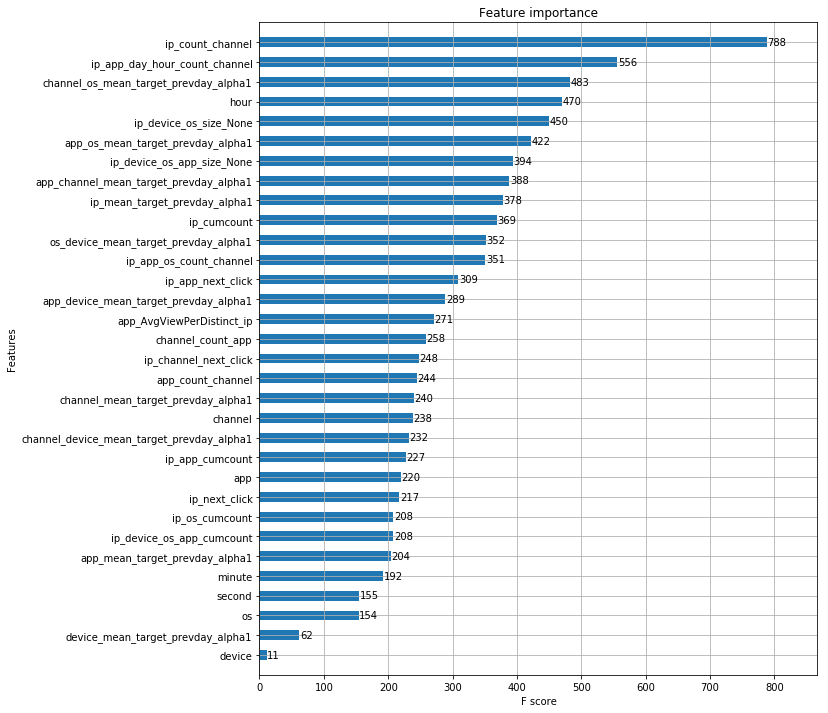

In [9]:
fig, ax = plt.subplots(figsize=(10,12))
xgb.plot_importance(xgb_model,ax=ax,height=.5)

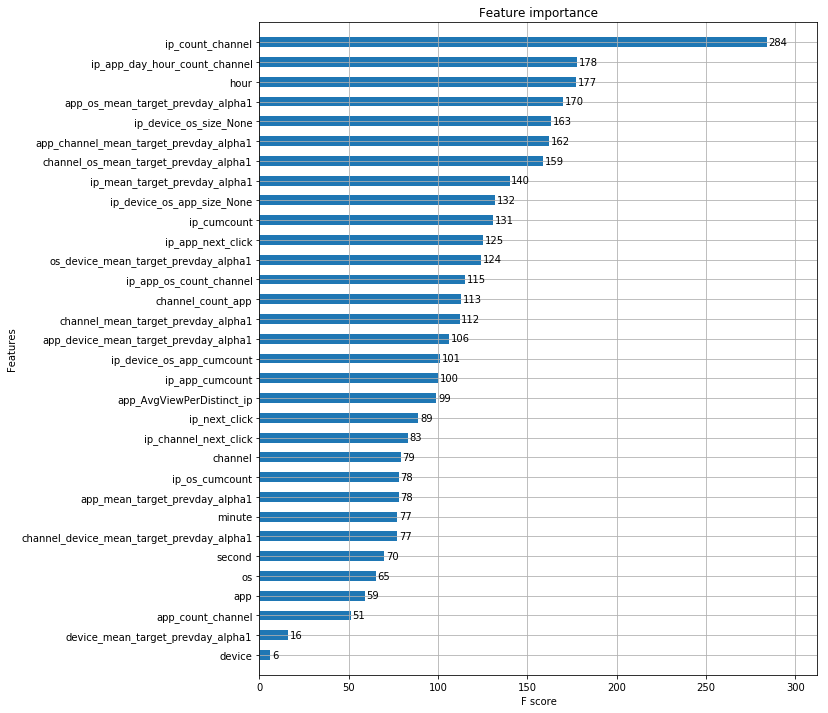

In [10]:
# fig, ax = plt.subplots(figsize=(10,12))
# xgb.plot_importance(xgb_model,ax=ax,height=.5)

In [10]:
xgb_model.save_model(str(PATH/'xgb2.model'))
xgb_model.__del__()
gc.collect()

5

In [11]:

xgb_model = xgb.Booster({'nthread': 4})  # init model
xgb_model.load_model(str(PATH/'xgb2.model'))  # load data


In [12]:
test = get_feather('test_FE.feather')

test.drop(cols_to_drop[1:],axis=1,inplace=True)

test.shape

(18790469, 32)

In [13]:
dtest = xgb.DMatrix(test)

del test
gc.collect()

28

In [14]:
pred = xgb_model.predict(dtest)

In [15]:
sub = pd.read_csv(PATH/'sample_submission.csv')
sub.is_attributed = pred
sub.tail()

,click_id,is_attributed
18790464,18790464,0.075239
18790465,18790465,0.001511
18790466,18790467,0.009274
18790467,18790466,0.028569
18790468,18790468,0.003615


In [16]:
sub.to_csv(PATH/'submission'/'second_best_XGB_day89_ratio3.csv',index=False)